In [1]:
import pickle

import numpyro
import numpyro.handlers as handlers
import jax.numpy as jnp
import jax
from numpyro.infer import Predictive

from src.models.M2VAE import M2VAE
from src.models.encoder_decoder import MNISTEncoder, MNISTDecoder, CIFAR10Encoder, CIFAR10Decoder
from src.data_loading.loaders import get_data_loaders

import matplotlib.pyplot as plt

/users/eleves-a/2020/david.heurtel-depeiges/Desktop/CCVAE_Jax/pgm/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up random seed
seed = 42

# DATASET
dataset_name = "CELEBA" #"MNIST" # use "CIFAR10" or "CELEBA"

encoder_class = MNISTEncoder if dataset_name=="MNIST" else CIFAR10Encoder
decoder_class = MNISTDecoder if dataset_name=="MNIST" else CIFAR10Decoder
distribution = "bernoulli" if dataset_name=="MNIST" else "laplace"

In [3]:
img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.2, 
                                          p_val=0.2, 
                                          p_supervised=0.05, 
                                          batch_size=10, 
                                          num_workers=0, 
                                          seed=seed)

scale_factor = 1.

Successfully loaded CELEBA dataset.
Total num samples 202599
Num test samples: 40519
Num validation samples: 32416
Num supervised samples: 6483
Num unsupervised samples: 123181


In [4]:
batch = next(iter(loader_dict["validation"]))

/users/eleves-a/2020/david.heurtel-depeiges/Desktop/CCVAE_Jax/pgm/lib64/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
batch[0].shape

(10, 64, 64, 3)

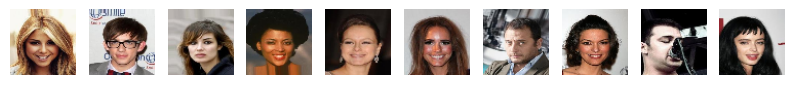

In [6]:
## Print some images of batch

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].imshow(batch[0][i])
    ax[i].axis("off")


In [ ]:
m2_vae = M2VAE(encoder_class, 
               decoder_class, 
               10, 
               50, 
               img_shape, 
               scale_factor=scale_factor, 
               distribution=distribution
)

In [ ]:
with open("./model_weights/m2" + dataset_name + ".pkl", 'rb') as file:
    params=pickle.load(file)

In [ ]:
#xs = jnp.zeros((10,) + img_shape)
#ys = jnp.array([i for i in range(10)])


# OR 
load = iter(loader_dict["test"])
xs, ys = next(load)

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        image = xs[i * n_cols + j]
        
        if dataset_name == "MNIST":
            image = image.squeeze(-1)
            plt.imshow(image, cmap='gray')
        elif dataset_name == "CIFAR10":
            plt.imshow(image)
        plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
print(xs.shape, ys.shape)

In [ ]:
predictive = Predictive(m2_vae.model_supervised, guide=m2_vae.guide_supervised, params=params, num_samples=25, return_sites=["loc"])

rng_key = jax.random.PRNGKey(0) 
predictions = predictive(rng_key, xs, ys)

loc = predictions['loc']

print(loc.shape)

In [ ]:
class_number = 3

In [ ]:
n_rows = 5
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i, class_number]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    elif dataset_name == "CIFAR10":
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()